In [ ]:
# Install necessary libraries
!pip install --upgrade scikit-learn
!pip install scikit-image==0.19.3
!pip install opencv-python-headless matplotlib

# Import libraries
import numpy as np
import cv2
import os
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from skimage.feature import greycomatrix, greycoprops
from joblib import load
from google.colab import drive

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 47.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.24.0
    Uninstalling scikit-image-0.24.0:
      Successfully uninstalled scikit-image-0.24.0


In [ ]:
# Step 1: Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')

# Step 2: Automate dataset handling (download and extraction)
dataset_zip_path = '/content/drive/MyDrive/CSC667/DATASET.zip'

Mounting Google Drive...
Mounted at /content/drive


In [ ]:
# Extract dataset
print("Extracting the dataset...")
extracted_path = 'dataset'
with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)
print("Dataset extracted!")

Extracting the dataset...
Dataset extracted!


In [ ]:
# Step 3: Load and preprocess data
def load_images_labels(data_dir, subset_size=None):

    #Load images and labels from the dataset directory.
   # Optionally slice the dataset to a subset_size for faster processing.

    images, labels = [], []
    for label_dir in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_dir)
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                try:
                    img = cv2.imread(img_path)
                    if img is None:
                        continue  # Skip invalid images
                    img = cv2.resize(img, (128, 128))  # Resize for uniformity
                    images.append(img)
                    labels.append(label_dir)
                    # Stop if subset size is reached
                    if subset_size and len(images) >= subset_size:
                        break
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
            if subset_size and len(images) >= subset_size:
                break
    return np.array(images), np.array(labels)

# Load dataset
subset_size = 5000
data_dir = 'dataset/PlantVillage'
images, labels = load_images_labels(data_dir, subset_size=subset_size)

In [ ]:
# Step 4: Encode Labels
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

In [ ]:
# Step 5: Feature Extraction
def extract_features(images):
    """
    Extract features from images: mean RGB (color), texture (GLCM), and shape (edge area).
    """
    features = []
    for img in images:
        # Color Features (Mean RGB)
        mean_rgb = cv2.mean(img)[:3]

        # Convert to grayscale for texture and shape features
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Texture Features (GLCM)
        glcm = greycomatrix(gray, [1], [0], 256, symmetric=True, normed=True)
        texture_features = [
            greycoprops(glcm, 'contrast')[0, 0],
            greycoprops(glcm, 'dissimilarity')[0, 0],
            greycoprops(glcm, 'homogeneity')[0, 0],
            greycoprops(glcm, 'energy')[0, 0],
            greycoprops(glcm, 'correlation')[0, 0]
        ]

        # Shape Features (Edge detection and area)
        edges = cv2.Canny(gray, 100, 200)
        area = np.sum(edges / 255)

        # Combine features
        features.append(np.hstack([mean_rgb, texture_features, area]))
    return np.array(features)

# Extract features
features = extract_features(images)


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0

In [ ]:
# Step 6: Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

In [ ]:
# Step 7: Load the pre-trained model
print("Loading the saved model...")
model_path = '/content/drive/MyDrive/CSC667/best_model.joblib'
best_model = load(model_path)
print("Model loaded successfully!")

Loading the saved model...
Model loaded successfully!


In [ ]:
# Step 8: Evaluate the Model
print("Evaluating the model...")
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

Evaluating the model...
Model Accuracy: 0.81


In [ ]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))


Classification Report:
                           precision    recall  f1-score   support

   Pepper__bell___healthy       0.84      0.90      0.87       281
      Tomato_Early_blight       0.84      0.82      0.83       216
Tomato_Septoria_leaf_spot       0.72      0.55      0.63       217
      Tomato__Target_Spot       0.79      0.89      0.84       286

                 accuracy                           0.81      1000
                macro avg       0.80      0.79      0.79      1000
             weighted avg       0.80      0.81      0.80      1000




Confusion Matrix:


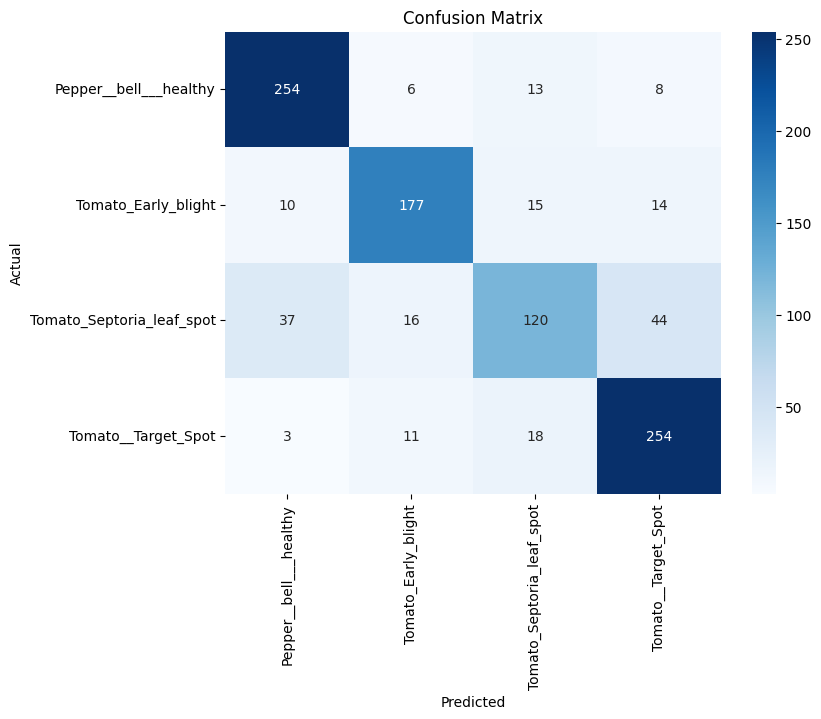

In [ ]:
# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)

# Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# Step 9: Live testing with a single image
def preprocess_and_predict_image(image_path):
    """
    Preprocess and predict the class of a single image.
    """
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        return "Error: Image not found."

    # Preprocess the image
    img = cv2.resize(img, (128, 128))
    mean_rgb = cv2.mean(img)[:3]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Texture Features (GLCM)
    glcm = greycomatrix(gray, [1], [0], 256, symmetric=True, normed=True)
    texture_features = [
        greycoprops(glcm, 'contrast')[0, 0],
        greycoprops(glcm, 'dissimilarity')[0, 0],
        greycoprops(glcm, 'homogeneity')[0, 0],
        greycoprops(glcm, 'energy')[0, 0],
        greycoprops(glcm, 'correlation')[0, 0]
    ]

    # Shape Features (Edge detection and area)
    edges = cv2.Canny(gray, 100, 200)
    area = np.sum(edges / 255)

    # Combine all features
    features = np.hstack([mean_rgb, texture_features, area]).reshape(1, -1)

    # Predict the class
    predicted_label = best_model.predict(features)[0]
    return encoder.classes_[predicted_label]

# Step 9B: Test a specific image from the dataset (one-line code)
image_index = 0  # Change the index to test different images
print(f"Predicted: {encoder.classes_[best_model.predict([X_test[image_index]])[0]]}, Actual: {encoder.classes_[y_test[image_index]]}")


Predicted: Pepper__bell___healthy, Actual: Pepper__bell___healthy
